In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('cs-training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [3]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
# Limiting to 100K to save remaining 50K for ongoing model testing
df1 = df[:100000]

Strong correlation between `NumberOfTime30-59DaysPastDueNotWorse`,`NumberOfTime60-89DaysPastDueNotWorse` and `NumberofTimes90DaysLate`. Can drop 2 of these from analysis.

In [5]:
X = df1.drop(columns=['SeriousDlqin2yrs','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'])
y = df1['SeriousDlqin2yrs']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                              y,
                                              test_size=.25, 
                                              random_state=12)

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [42]:
# Preprocessing for numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical features (impute missing with the mean)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])


# Combine both pipelines into a single column transformer
# (dropped scaling but may re integrate later)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features)
    ])

# Create the Random Forest pipeline
# Used class_weight='balanced' to account for the class imbalance. 
# This will give more weight to the minority class (delinquent). 
# This helps to improve recall (i.e., identifying more delinquent cases) but at the cost of precision (increased false positives).
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,class_weight='balanced'))
])

In [43]:
# Define the hyperparameters to search
param_grid = {
    'classifier__n_estimators': [100, 125],  # Number of trees
    'classifier__max_depth': [10, 15],  # Maximum depth of the trees
    # 'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # 'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    # 'classifier__class_weight': ['balanced', None]  # Class weighting for imbalance handling
}

# Initialize GridSearchCV with the pipeline and hyperparameters
# Given the domain of financial distress prediction, higher recall is preferred to avoid 
# missing delinquent cases that could result in financial losses.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 125}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89     23336
           1       0.21      0.68      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix for Best Model:
 [[18969  4367]
 [  529  1135]]


In [44]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=125, max_depth=10, random_state=42,class_weight='balanced'))
])

# copy the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Test cross-validation to assess the performance across multiple splits
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

AUC: 0.8269
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89     23336
           1       0.21      0.68      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix:
 [[18969  4367]
 [  529  1135]]
Cross-validation accuracy: 0.8025 ± 0.0029


In [45]:
# Perform cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation AUC: 0.8294 ± 0.0014


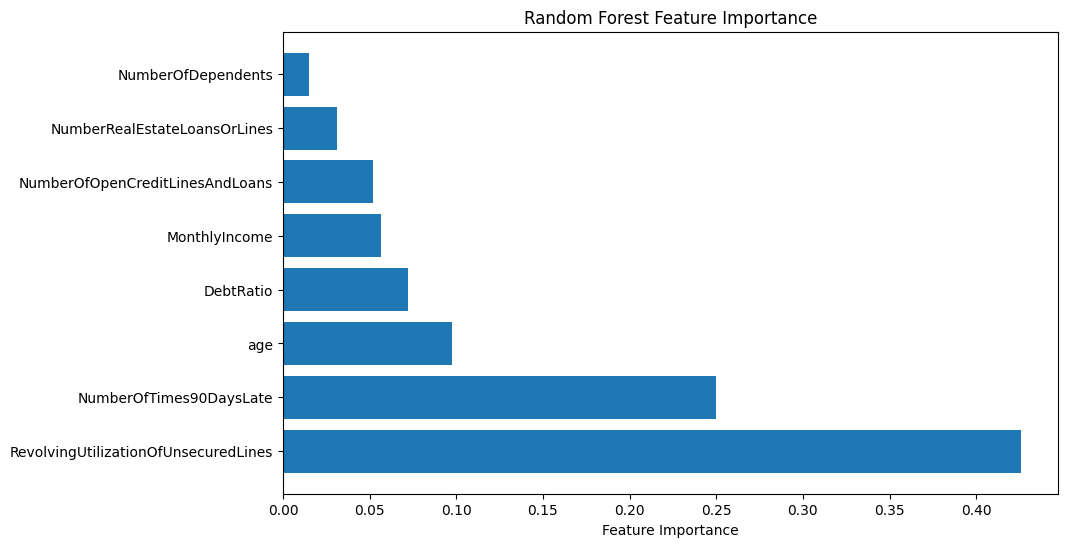

In [46]:
# Get feature importance from the trained Random Forest model
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
features = X.columns

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Now going to explore possible interactions between features to improve the model. Partial dependence plots can help identify feature interactions by showing how a feature affects the predicted outcome while controlling for the influence of other features:

In [20]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [56]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

In [ ]:
# X_train['group_90days_late'] = np.where(X_train['NumberOfTimes90DaysLate'] == 0, '0', X_train['NumberOfTimes90DaysLate'])
# X_train['group_90days_late'] = np.where((X_train['NumberOfTimes90DaysLate'] >= 1) & (X_train['NumberOfTimes90DaysLate'] <= 4), '1-4', '5+')

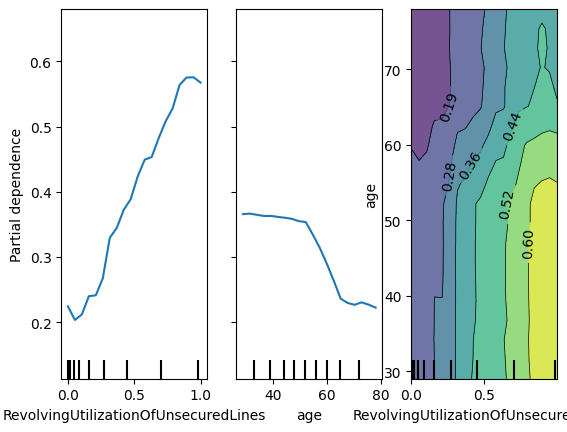

In [57]:
# Get partial dependence data 
top_features = [X.columns[i] for i in indices[:3]]
pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=['RevolvingUtilizationOfUnsecuredLines','age', ('RevolvingUtilizationOfUnsecuredLines','age')],
                                       kind='average',
                                       **common_params
                                       )



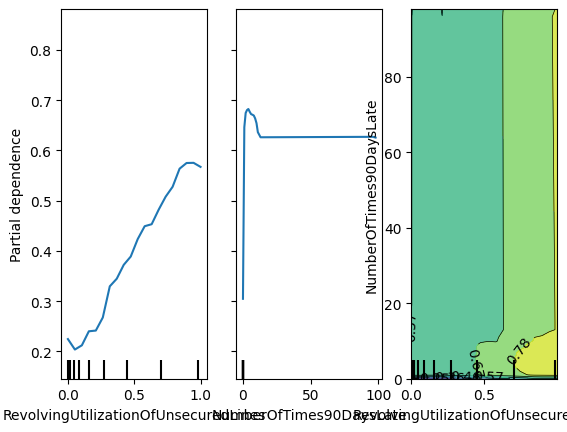

In [71]:
# Get partial dependence data 
top_features = [X.columns[i] for i in indices[:3]]
pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=['RevolvingUtilizationOfUnsecuredLines','NumberOfTimes90DaysLate', ('RevolvingUtilizationOfUnsecuredLines','NumberOfTimes90DaysLate')],
                                       kind='average',
                                       **common_params
                                       )

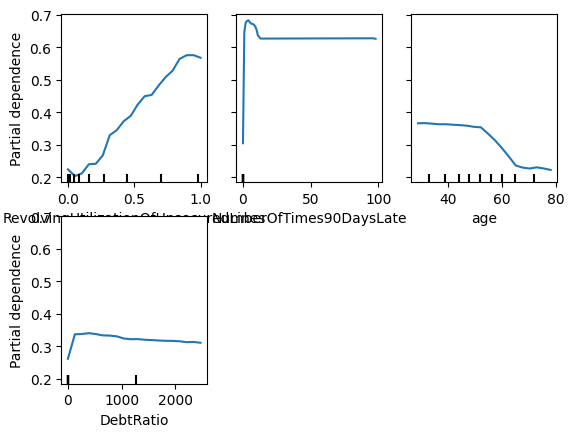

In [72]:
# Get partial dependence data 
top_features = [X.columns[i] for i in indices[:4]]
pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=top_features,
                                       kind='average',
                                       **common_params
                                       )

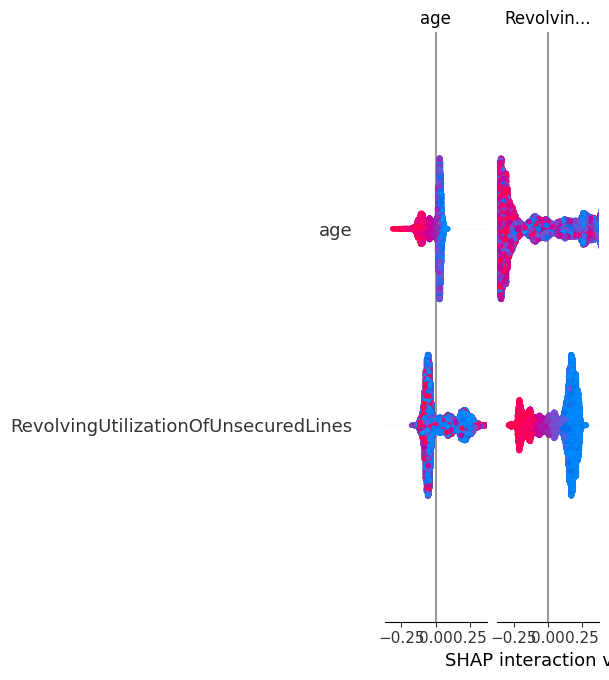

In [64]:
import shap

# Fit the model and explain it with SHAP
explainer = shap.TreeExplainer(model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot to understand feature interactions
shap.summary_plot(shap_values, X_test)


In [30]:
# Retrain on the full dataset
model_pipeline.fit(X, y)  # Use the entire dataset (X and y)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [31]:
X_holdout = df.iloc[100001:105000].drop(columns=['SeriousDlqin2yrs','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'])
y_holdout = df.iloc[100001:105000]['SeriousDlqin2yrs']

In [32]:
# Predict on the test set
y_pred_holdout = model_pipeline.predict(X_holdout)
y_prob_holdout = model_pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_holdout, y_prob_holdout)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_holdout, y_pred_holdout))
print("Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred_holdout))

AUC: 0.8097
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4659
           1       0.27      0.53      0.36       340

    accuracy                           0.87      4999
   macro avg       0.62      0.71      0.64      4999
weighted avg       0.92      0.87      0.89      4999

Confusion Matrix:
 [[4171  488]
 [ 160  180]]


# Now test XGBoost

In [ ]:
import xgboost as xgb

In [21]:
# Preprocessing for numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical features (impute missing with the mean)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])


# Combine both pipelines into a single column transformer
# (dropped scaling but may re integrate later)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features)
    ])

# Create the XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', xgb.XGBClassifier(objective="binary:logistic", random_state=42))
])


In [41]:
# Define the hyperparameters to search
param_grid = {
    'classifier__max_depth': [6, 8, 10],  # Maximum depth of the trees
    'classifier__max_delta_step': [2, 4, 6],  
    'classifier__scale_pos_weight': [5, 8, 10, 20], 
    'classifier__learning_rate': [0.01, 0.05],
    # 'classifier__n_estimators': [50, 100, 200],
    'classifier__subsample': [0.7, 0.8],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__min_child_weight': [1, 2]
}

# Initialize GridSearchCV with the pipeline and hyperparameters
# Given the domain of financial distress prediction, higher recall is preferred to avoid 
# missing delinquent cases that could result in financial losses.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best Hyperparameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_delta_step': 2, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 20, 'classifier__subsample': 0.8}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.98      0.61      0.76     23336
           1       0.14      0.85      0.23      1664

    accuracy                           0.63     25000
   macro avg       0.56      0.73      0.50     25000
weighted avg       0.93      0.63      0.72     25000

Confusion Matrix for Best Model:
 [[14341  8995]
 [  252  1412]]


In [28]:
# Create the XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', xgb.XGBClassifier(objective="binary:logistic",
                                     max_delta_step= 0,
                                     max_depth=6, 
                                     scale_pos_weight= 8,
                                     random_state=42))
])

In [29]:
# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Test cross-validation to assess the performance across multiple splits
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

AUC: 0.8113
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23336
           1       0.27      0.53      0.36      1664

    accuracy                           0.87     25000
   macro avg       0.62      0.71      0.64     25000
weighted avg       0.92      0.87      0.89     25000

Confusion Matrix:
 [[20948  2388]
 [  780   884]]
Cross-validation accuracy: 0.8706 ± 0.0020


In [33]:
# Retrain on the full dataset
model_pipeline.fit(X, y)  # Use the entire dataset (X and y)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [34]:
# Predict on the test set
y_pred_holdout = model_pipeline.predict(X_holdout)
y_prob_holdout = model_pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_holdout, y_prob_holdout)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_holdout, y_pred_holdout))
print("Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred_holdout))

AUC: 0.8097
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4659
           1       0.27      0.53      0.36       340

    accuracy                           0.87      4999
   macro avg       0.62      0.71      0.64      4999
weighted avg       0.92      0.87      0.89      4999

Confusion Matrix:
 [[4171  488]
 [ 160  180]]


# Feature engineering

In [34]:
X_train['DebtRatio'] = np.where(X_train['DebtRatio'] > 10, 10, X_train['DebtRatio'])
X_train['NumberOfTimes90DaysLate'] = np.where(X_train['NumberOfTimes90DaysLate'] >20 ,X_train['NumberOfTimes90DaysLate'].mean(), X_train['NumberOfTimes90DaysLate'])
X_train['RevolvingUtilizationOfUnsecuredLines'] = np.where(X_train['RevolvingUtilizationOfUnsecuredLines']>2 ,2, X_train['RevolvingUtilizationOfUnsecuredLines'])
X_train['age'] = np.where(X_train['age']>90 ,90, X_train['age'])

X_test['DebtRatio'] = np.where(X_test['DebtRatio'] > 10, 10, X_test['DebtRatio'])
X_test['NumberOfTimes90DaysLate'] = np.where(X_test['NumberOfTimes90DaysLate'] >20 ,X_test['NumberOfTimes90DaysLate'].mean(), X_test['NumberOfTimes90DaysLate'])
X_test['RevolvingUtilizationOfUnsecuredLines'] = np.where(X_test['RevolvingUtilizationOfUnsecuredLines']>2 ,2, X_test['RevolvingUtilizationOfUnsecuredLines'])
X_test['age'] = np.where(X_test['age']>90 ,90, X_test['age'])

In [45]:
# # Create the 'group_90days_late' feature
X_train['group_90days_late'] = np.where(X_train['NumberOfTimes90DaysLate'] == 0, '0', 
                                        np.where((X_train['NumberOfTimes90DaysLate'] >= 1) & 
                                                 (X_train['NumberOfTimes90DaysLate'] <= 4), '1-4', '5+'))

X_test['group_90days_late'] = np.where(X_test['NumberOfTimes90DaysLate'] == 0, '0', 
                                        np.where((X_test['NumberOfTimes90DaysLate'] >= 1) & 
                                                 (X_test['NumberOfTimes90DaysLate'] <= 4), '1-4', '5+'))

# Drop the 'NumberOfTimes90DaysLate' column
X_train.drop(columns=['NumberOfTimes90DaysLate'], inplace=True)
X_test.drop(columns=['NumberOfTimes90DaysLate'], inplace=True)

In [46]:
X_train['credit_usage_age'] = X_train['age'] * X_train['RevolvingUtilizationOfUnsecuredLines']
X_test['credit_usage_age'] = X_test['age'] * X_test['RevolvingUtilizationOfUnsecuredLines']

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
# Preprocessing for numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocessing pipeline for numerical features (impute missing with the mean)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])

# Preprocessing pipeline for categorical features (one-hot encode)
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))  # One-hot encode the categories
])


# Combine both pipelines into a single column transformer
# (dropped scaling but may re integrate later)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Create the Random Forest pipeline
# Used class_weight='balanced' to account for the class imbalance. 
# This will give more weight to the minority class (delinquent). 
# This helps to improve recall (i.e., identifying more delinquent cases) but at the cost of precision (increased false positives).
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,class_weight='balanced'))
])

In [48]:
# Define the hyperparameters to search
param_grid = {
    'classifier__n_estimators': [100, 125],  # Number of trees
    'classifier__max_depth': [10, 15],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # 'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    # 'classifier__class_weight': ['balanced', None]  # Class weighting for imbalance handling
}

# Initialize GridSearchCV with the pipeline and hyperparameters
# Given the domain of financial distress prediction, higher recall is preferred to avoid 
# missing delinquent cases that could result in financial losses.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88     23336
           1       0.21      0.69      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix for Best Model:
 [[18924  4412]
 [  508  1156]]


In [98]:
# X_copy = X.copy()
# y_copy = y.copy()

# X_train['DebtRatio'] = np.where(X_train['DebtRatio'] > 10, 10, X_train['DebtRatio'])
# X_train['NumberOfTimes90DaysLate'] = np.where(X_train['NumberOfTimes90DaysLate'] >20 ,X_train['NumberOfTimes90DaysLate'].mean(), X_train['NumberOfTimes90DaysLate'])
# X_train['RevolvingUtilizationOfUnsecuredLines'] = np.where(X_train['RevolvingUtilizationOfUnsecuredLines']>2 ,2, X_train['RevolvingUtilizationOfUnsecuredLines'])

# X_test['DebtRatio'] = np.where(X_test['DebtRatio'] > 10, 10, X_test['DebtRatio'])
# X_test['NumberOfTimes90DaysLate'] = np.where(X_test['NumberOfTimes90DaysLate'] >20 ,X_test['NumberOfTimes90DaysLate'].mean(), X_test['NumberOfTimes90DaysLate'])
# X_test['RevolvingUtilizationOfUnsecuredLines'] = np.where(X_test['RevolvingUtilizationOfUnsecuredLines']>2 ,2, X_test['RevolvingUtilizationOfUnsecuredLines'])

# # # Create the 'group_90days_late' feature
# X_copy['group_90days_late'] = np.where(X_copy['NumberOfTimes90DaysLate'] == 0, '0', 
#                                         np.where((X_copy['NumberOfTimes90DaysLate'] >= 1) & 
#                                                  (X_copy['NumberOfTimes90DaysLate'] <= 4), '1-4', '5+'))

# # Drop the 'NumberOfTimes90DaysLate' column
# X_copy.drop(columns=['NumberOfTimes90DaysLate'], inplace=True)

# X_copy['credit_usage_age'] = X_copy['age'] * X_copy['RevolvingUtilizationOfUnsecuredLines']


In [49]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=125,
                                          max_depth=10,
                                          min_samples_split=10,
                                          random_state=42,
                                          class_weight='balanced'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Test cross-validation to assess the performance across multiple splits
cv_scores = cross_val_score(model_pipeline, X_test, y_test, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

AUC: 0.8266
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88     23336
           1       0.21      0.69      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix:
 [[18908  4428]
 [  516  1148]]
Cross-validation accuracy: 0.8414 ± 0.0049


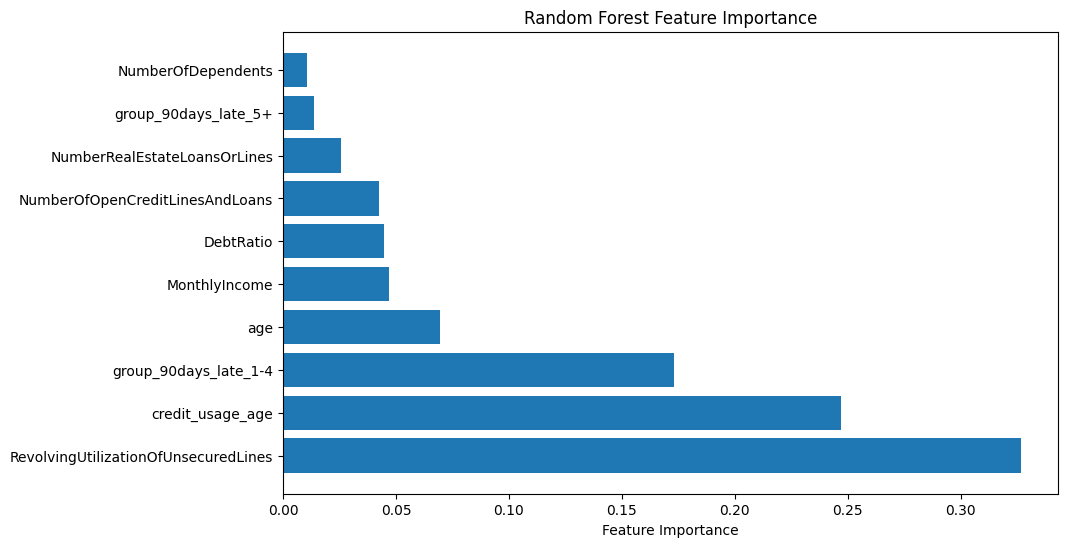

In [50]:
# Get the feature names after preprocessing
preprocessed_X = preprocessor.transform(X_train)  # Transform X_train using the preprocessor

# The transformed features are stored as a sparse matrix, so we need to extract the feature names
# If categorical features were one-hot encoded, we can extract the column names from the one-hot encoder
one_hot_columns = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine the numerical features and one-hot encoded features
all_feature_names = list(numerical_features) + list(one_hot_columns)

# Get feature importances from the trained Random Forest model
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


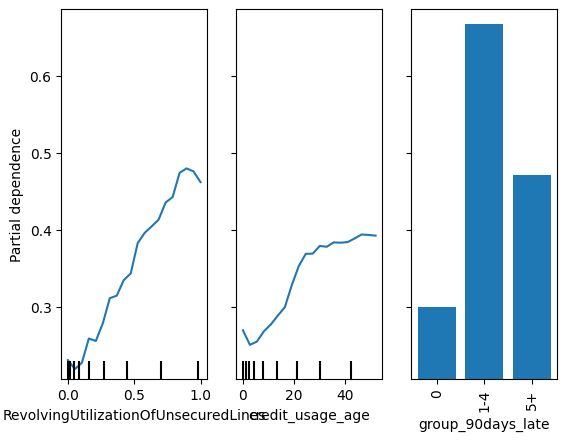

In [51]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# Get partial dependence data 
indices = np.argsort(feature_importances)[::-1]
top_features = [X_train.columns[i] for i in indices[:3]]

pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=top_features,
                                       kind='average',
                                       categorical_features=['group_90days_late'],
                                       
                                       **common_params
                                       )



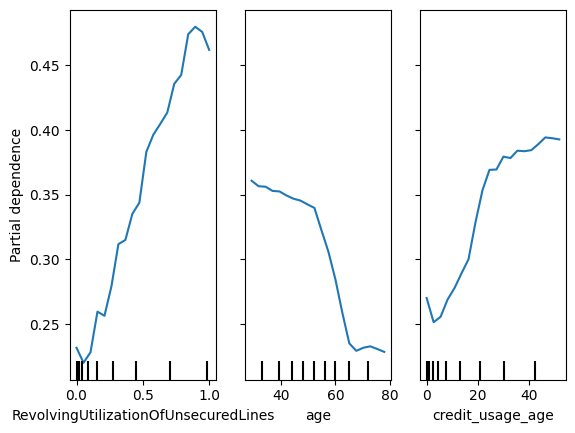

In [52]:

pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=['RevolvingUtilizationOfUnsecuredLines','age','credit_usage_age'],
                                       kind='average',
                                       **common_params
                                       )

<Axes: xlabel='age'>

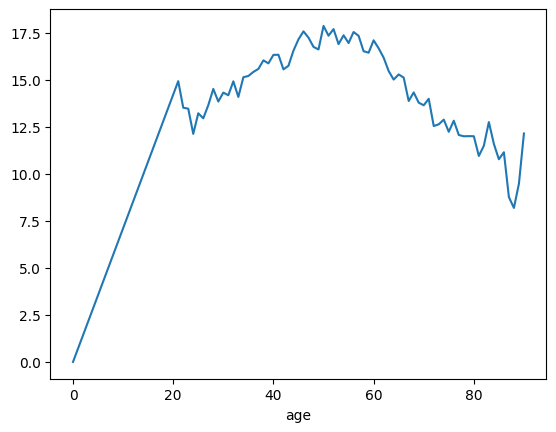

In [53]:
X_train.groupby('age').credit_usage_age.mean().plot()

<Axes: xlabel='age'>

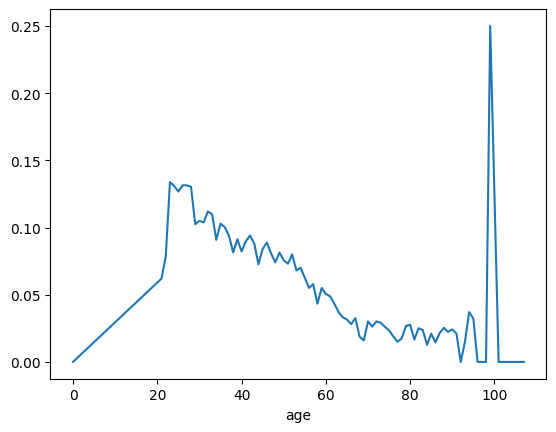

In [54]:
df1.groupby('age').SeriousDlqin2yrs.mean().plot()

In [29]:
df1.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [27]:
X_train[X_train['age']>= 95].head(60)

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,group_90days_late,credit_usage_age
57967,0.001397,103,10.000000,1.0,11,2,0.0,0,0.143868
82440,1.000000,95,0.131434,2000.0,7,0,0.0,0,94.999991
78003,0.040966,96,10.000000,NaN,5,0,0.0,0,3.932722
19884,1.000000,103,0.000000,1600.0,3,0,0.0,0,102.999990
95188,0.005700,95,3.000000,NaN,1,0,NaN,0,0.541473
72551,0.022915,96,0.007623,7083.0,5,0,0.0,0,2.199884
48964,0.008689,97,0.001650,6666.0,2,0,0.0,0,0.842804
84641,0.036041,95,0.251171,6831.0,5,1,0.0,0,3.423928
67727,0.020057,95,0.002897,7249.0,2,0,1.0,0,1.905374
61851,0.048969,95,0.264611,2788.0,12,1,0.0,0,4.652029
